Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License. 

# VISTA-2D Cell Segmentation with Segment Anything Model (SAM) & MONAI

![image](../figures/vista_2d_overview.png)

The tutorial demonstrates how to train a cell segmentation model using the [MONAI](https://monai.io/) framework and the [Segment Anything Model (SAM)](https://github.com/facebookresearch/segment-anything) on the [Cellpose dataset](https://www.cellpose.org/).
In Summary the following steps are performed:
- Initialization of the CellSamWrapper model with pre-trained SAM weights
- Creation of data lists for training, validation, and testing
- Definition of data transforms for training and validation
- Setup of datasets and dataloaders with MONAI
- Implementation of the training loop, including:
    - Loss function (CellLoss)
    - Accuracy function (CellAcc)
    - Optimizer (SGD)
- Mixed precision training with GradScaler
- Sliding window inference via MONAI
- Visualization of training loss, validation loss, and validation accuracy
- Inference on a single validation image
- Visualization of input image, ground truth, and model prediction

The notebook demonstrates a complete pipeline for training and evaluating a cell segmentation model using the MONAI framework and the Segment Anything Model (SAM) on the Cellpose dataset. Please note we only use a small subset of the cellpose dataset for this tutorial.

For additional information about VISTA-2D please also refer the [MONAI bundle](https://github.com/Project-MONAI/VISTA/tree/main/vista2d) and the [technical blog post](https://developer.nvidia.com/blog/advancing-cell-segmentation-and-morphology-analysis-with-nvidia-ai-foundation-model-vista-2d/).

## Setup environment

In [ ]:
!pip install monai fire tifffile imagecodecs pillow fastremap
!pip install --no-deps cellpose natsort roifile
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install ipykernel
!pip install opencv-python-headless
!pip install tqdm
!pip install numba
%matplotlib inline

## Setup imports

In [1]:
from monai.transforms import Compose, LoadImage, EnsureChannelFirst, ScaleIntensity
from cell_sam_wrapper import CellSamWrapper
import os
import json
import time
import torch
import numpy as np
import matplotlib.pyplot as plt

import monai.transforms as mt
from monai.data import DataLoader, Dataset
from monai.metrics import CumulativeAverage
from monai.inferers import SlidingWindowInfererAdapt
from monai.config import print_config
from monai.utils import ImageMetaKey
from torch.cuda.amp import GradScaler, autocast

from components import LabelsToFlows, LoadTiffd, LogitsToLabels
from components import CellLoss, CellAcc

import importlib
import cell_sam_wrapper
importlib.reload(cell_sam_wrapper)

print_config()

The Cellpose dataset needs to be downloaded from [this link](https://www.cellpose.org/).
The SAM weights need to be downloaded [from here](https://github.com/facebookresearch/segment-anything). The exact filename of weights that has been used for this tutorial is `sam_vit_b_01ec64.pth` 

In [2]:
# Paths of training data, testing data and output log files
data_list_path = 'cellpose_toy_datalist.json'
data_root = os.path.normpath('/home/vnath/Downloads/cellpose_dataset/')
sam_weights_path = os.path.normpath('/home/vnath/Downloads/cellpose_dataset/sam_vit_b_01ec64.pth')

# Define the network, load SAM weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CellSamWrapper(checkpoint=sam_weights_path)
model.to(device)
print('SAM ViT-B weights loaded succesfully ...')

CellSamWrapper auto_resize_inputs True network_resize_roi [1024, 1024] checkpoint /home/vnath/Downloads/cellpose_dataset/sam_vit_b_01ec64.pth


/home/vnath/anaconda3/envs/py311_vista_2d/lib/python3.11/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.lo

SAM ViT-B weights loaded succesfully ...


In [3]:
# Create Required Data lists
# Append root path to training, validation and testing data list
with open(data_list_path, 'r') as f:
    data = json.load(f)

validation_fold = 0
training_list = []
validation_list = []
testing_list = []

# Process training data
for item in data.get("training", []):
    # Append the base path to image and label
    item["image"] = os.path.join(data_root, item["image"])
    item["label"] = os.path.join(data_root, item["label"])

    if item["fold"] == validation_fold:
        validation_list.append(item)
    else:
        training_list.append(item)

# Process testing data
for item in data.get("testing", []):
    # Append the base path to image and label
    item["image"] = os.path.join(data_root, item["image"])
    item["label"] = os.path.join(data_root, item["label"])
    testing_list.append(item)

print('Appended Data Root to Json file list ...')
print('Total Training Data: {}'.format(len(training_list)))
print('Total Validation Data: {}'.format(len(validation_list)))
print('Total Testing Data: {}'.format(len(testing_list)))

Appended Data Root to Json file list ...
Total Training Data: 40
Total Validation Data: 10
Total Testing Data: 68


/tmp/ipykernel_1742509/3523808337.py:116: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/home/vnath/anaconda3/envs/py311_vista_2d/lib/python3.11/site-packages/monai/transforms/intensity/array.py:996: Warning: Divide by zero (a_min == a_max)
  warn("Divide by zero (a_min == a_max)", Warning)
/home/vnath/anaconda3/envs/py311_vista_2d/lib/python3.11/site-packages/monai/transforms/intensity/array.py:996: Warning: Divide by zero (a_min == a_max)
  warn("Divide by zero (a_min == a_max)", Warning)
/tmp/ipykernel_1742509/3523808337.py:153: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=amp_dtype):


Epoch 0/10 0/20 
loss: 6.8427 time 1.91s 
Epoch 0/10 1/20 
loss: 6.2180 time 2.39s 
Epoch 0/10 2/20 
loss: 5.6889 time 2.88s 
Epoch 0/10 3/20 
loss: 5.8097 time 3.35s 
Epoch 0/10 4/20 
loss: 5.1125 time 3.83s 
Epoch 0/10 5/20 
loss: 4.8036 time 4.31s 
Epoch 0/10 6/20 
loss: 4.3837 time 4.79s 
Epoch 0/10 7/20 
loss: 4.4070 time 5.27s 
Epoch 0/10 8/20 
loss: 4.1337 time 5.75s 
Epoch 0/10 9/20 
loss: 4.1337 time 6.23s 
Epoch 0/10 10/20 
loss: 4.0127 time 6.74s 
Epoch 0/10 11/20 
loss: 3.8947 time 7.23s 
Epoch 0/10 12/20 
loss: 3.8678 time 7.73s 
Epoch 0/10 13/20 
loss: 3.7861 time 8.22s 
Epoch 0/10 14/20 
loss: 3.6749 time 8.70s 
Epoch 0/10 15/20 
loss: 3.5916 time 9.19s 
Epoch 0/10 16/20 
loss: 3.4992 time 9.67s 
Epoch 0/10 17/20 
loss: 3.4314 time 10.16s 
Epoch 0/10 18/20 
loss: 3.4150 time 10.65s 
Epoch 0/10 19/20 
loss: 3.3908 time 11.14s 


/home/vnath/anaconda3/envs/py311_vista_2d/lib/python3.11/site-packages/monai/transforms/intensity/array.py:996: Warning: Divide by zero (a_min == a_max)
  warn("Divide by zero (a_min == a_max)", Warning)
/home/vnath/anaconda3/envs/py311_vista_2d/lib/python3.11/site-packages/monai/transforms/intensity/array.py:996: Warning: Divide by zero (a_min == a_max)
  warn("Divide by zero (a_min == a_max)", Warning)
/tmp/ipykernel_1742509/3523808337.py:220: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=amp_dtype):


Val 0/10 0/10 
loss: 1.5099 acc 0.0  time 13.72s


/tmp/ipykernel_1742509/3523808337.py:220: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=amp_dtype):


Val 0/10 1/10 
loss: 1.5080 acc 0.0  time 14.62s
Val 0/10 2/10 
loss: 1.6668 acc 0.0  time 15.48s
Val 0/10 3/10 
loss: 3.9058 acc 0.0  time 16.15s
Val 0/10 4/10 
loss: 3.1426 acc 0.0  time 16.75s
Val 0/10 5/10 
loss: 2.2726 acc 0.0  time 17.32s
Val 0/10 6/10 
loss: 4.1573 acc 0.0  time 17.91s
Val 0/10 7/10 
loss: 2.6014 acc 0.0  time 18.51s
Val 0/10 8/10 
loss: 2.8091 acc 0.0  time 19.10s
Val 0/10 9/10 
loss: 1.6383 acc 0.0  time 19.94s


/home/vnath/anaconda3/envs/py311_vista_2d/lib/python3.11/site-packages/monai/transforms/intensity/array.py:996: Warning: Divide by zero (a_min == a_max)
  warn("Divide by zero (a_min == a_max)", Warning)
/home/vnath/anaconda3/envs/py311_vista_2d/lib/python3.11/site-packages/monai/transforms/intensity/array.py:996: Warning: Divide by zero (a_min == a_max)
  warn("Divide by zero (a_min == a_max)", Warning)
/tmp/ipykernel_1742509/3523808337.py:153: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=amp_dtype):


Epoch 1/10 0/20 
loss: 2.2260 time 0.75s 
Epoch 1/10 1/20 
loss: 1.6868 time 1.21s 
Epoch 1/10 2/20 
loss: 1.9847 time 1.66s 
Epoch 1/10 3/20 
loss: 1.9931 time 2.12s 
Epoch 1/10 4/20 
loss: 2.5921 time 2.57s 
Epoch 1/10 5/20 
loss: 2.6148 time 3.03s 
Epoch 1/10 6/20 
loss: 2.8114 time 3.49s 
Epoch 1/10 7/20 
loss: 2.8880 time 3.94s 
Epoch 1/10 8/20 
loss: 2.9177 time 4.40s 
Epoch 1/10 9/20 
loss: 3.0904 time 4.85s 
Epoch 1/10 10/20 
loss: 3.0761 time 5.30s 
Epoch 1/10 11/20 
loss: 3.0976 time 5.76s 
Epoch 1/10 12/20 
loss: 3.0496 time 6.26s 
Epoch 1/10 13/20 
loss: 3.0329 time 6.75s 
Epoch 1/10 14/20 
loss: 2.9961 time 7.25s 
Epoch 1/10 15/20 
loss: 2.9876 time 7.73s 
Epoch 1/10 16/20 
loss: 2.9244 time 8.20s 
Epoch 1/10 17/20 
loss: 2.9006 time 8.69s 
Epoch 1/10 18/20 
loss: 2.9172 time 9.17s 
Epoch 1/10 19/20 
loss: 2.9682 time 9.65s 


/home/vnath/anaconda3/envs/py311_vista_2d/lib/python3.11/site-packages/monai/transforms/intensity/array.py:996: Warning: Divide by zero (a_min == a_max)
  warn("Divide by zero (a_min == a_max)", Warning)
/home/vnath/anaconda3/envs/py311_vista_2d/lib/python3.11/site-packages/monai/transforms/intensity/array.py:996: Warning: Divide by zero (a_min == a_max)
  warn("Divide by zero (a_min == a_max)", Warning)


Epoch 2/10 0/20 
loss: 1.8947 time 0.81s 
Epoch 2/10 1/20 
loss: 1.7350 time 1.29s 
Epoch 2/10 2/20 
loss: 2.3595 time 1.77s 
Epoch 2/10 3/20 
loss: 2.2514 time 2.24s 
Epoch 2/10 4/20 
loss: 2.3207 time 2.72s 
Epoch 2/10 5/20 
loss: 2.3353 time 3.20s 
Epoch 2/10 6/20 
loss: 2.4110 time 3.68s 
Epoch 2/10 7/20 
loss: 2.6286 time 4.16s 
Epoch 2/10 8/20 
loss: 2.5229 time 4.64s 
Epoch 2/10 9/20 
loss: 2.6178 time 5.12s 
Epoch 2/10 10/20 
loss: 2.7180 time 5.61s 
Epoch 2/10 11/20 
loss: 2.6961 time 6.09s 
Epoch 2/10 12/20 
loss: 2.6802 time 6.57s 
Epoch 2/10 13/20 
loss: 2.7687 time 7.07s 
Epoch 2/10 14/20 
loss: 2.7692 time 7.57s 
Epoch 2/10 15/20 
loss: 2.7225 time 8.04s 
Epoch 2/10 16/20 
loss: 2.8561 time 8.48s 
Epoch 2/10 17/20 
loss: 2.8127 time 8.93s 
Epoch 2/10 18/20 
loss: 2.7669 time 9.39s 
Epoch 2/10 19/20 
loss: 2.7196 time 9.84s 


/home/vnath/anaconda3/envs/py311_vista_2d/lib/python3.11/site-packages/monai/transforms/intensity/array.py:996: Warning: Divide by zero (a_min == a_max)
  warn("Divide by zero (a_min == a_max)", Warning)
/home/vnath/anaconda3/envs/py311_vista_2d/lib/python3.11/site-packages/monai/transforms/intensity/array.py:996: Warning: Divide by zero (a_min == a_max)
  warn("Divide by zero (a_min == a_max)", Warning)


Val 2/10 0/10 
loss: 1.2908 acc 0.039473684210526314  time 10.98s
Val 2/10 1/10 
loss: 1.2359 acc 0.1566265060240964  time 11.82s
Val 2/10 2/10 
loss: 0.7975 acc 0.9264705882352942  time 12.65s
Val 2/10 3/10 
loss: 2.8158 acc 0.27906976744186046  time 13.30s
Val 2/10 4/10 
loss: 2.6479 acc 0.2857142857142857  time 13.88s
Val 2/10 5/10 
loss: 2.0630 acc 0.1  time 14.46s
Val 2/10 6/10 
loss: 3.5786 acc 0.0  time 15.04s
Val 2/10 7/10 
loss: 1.7467 acc 0.47126436781609193  time 15.62s
Val 2/10 8/10 
loss: 2.0453 acc 0.5238095238095238  time 16.20s
Val 2/10 9/10 
loss: 1.2764 acc 0.20634920634920634  time 17.09s


/home/vnath/anaconda3/envs/py311_vista_2d/lib/python3.11/site-packages/monai/transforms/intensity/array.py:996: Warning: Divide by zero (a_min == a_max)
  warn("Divide by zero (a_min == a_max)", Warning)
/home/vnath/anaconda3/envs/py311_vista_2d/lib/python3.11/site-packages/monai/transforms/intensity/array.py:996: Warning: Divide by zero (a_min == a_max)
  warn("Divide by zero (a_min == a_max)", Warning)


Epoch 3/10 0/20 
loss: 2.6237 time 0.99s 
Epoch 3/10 1/20 
loss: 2.5812 time 1.48s 
Epoch 3/10 2/20 
loss: 2.2758 time 1.97s 
Epoch 3/10 3/20 
loss: 2.5797 time 2.46s 
Epoch 3/10 4/20 
loss: 2.6541 time 2.96s 
Epoch 3/10 5/20 
loss: 2.6584 time 3.44s 
Epoch 3/10 6/20 
loss: 2.5657 time 3.94s 
Epoch 3/10 7/20 
loss: 2.4789 time 4.43s 
Epoch 3/10 8/20 
loss: 2.4487 time 4.92s 
Epoch 3/10 9/20 
loss: 2.4757 time 5.41s 
Epoch 3/10 10/20 
loss: 2.8024 time 5.88s 
Epoch 3/10 11/20 
loss: 2.8976 time 6.37s 
Epoch 3/10 12/20 
loss: 2.8069 time 6.85s 
Epoch 3/10 13/20 
loss: 2.8040 time 7.33s 
Epoch 3/10 14/20 
loss: 2.7991 time 7.81s 
Epoch 3/10 15/20 
loss: 2.7461 time 8.29s 
Epoch 3/10 16/20 
loss: 2.7949 time 8.77s 
Epoch 3/10 17/20 
loss: 2.8258 time 9.25s 
Epoch 3/10 18/20 
loss: 2.8295 time 9.73s 
Epoch 3/10 19/20 
loss: 2.8223 time 10.23s 


/home/vnath/anaconda3/envs/py311_vista_2d/lib/python3.11/site-packages/monai/transforms/intensity/array.py:996: Warning: Divide by zero (a_min == a_max)
  warn("Divide by zero (a_min == a_max)", Warning)
/home/vnath/anaconda3/envs/py311_vista_2d/lib/python3.11/site-packages/monai/transforms/intensity/array.py:996: Warning: Divide by zero (a_min == a_max)
  warn("Divide by zero (a_min == a_max)", Warning)


Epoch 4/10 0/20 
loss: 3.0028 time 1.17s 
Epoch 4/10 1/20 
loss: 2.3152 time 1.65s 
Epoch 4/10 2/20 
loss: 2.3115 time 2.15s 
Epoch 4/10 3/20 
loss: 2.6074 time 2.64s 
Epoch 4/10 4/20 
loss: 2.6409 time 3.13s 
Epoch 4/10 5/20 
loss: 2.6461 time 3.62s 
Epoch 4/10 6/20 
loss: 2.6341 time 4.10s 
Epoch 4/10 7/20 
loss: 2.7549 time 4.59s 
Epoch 4/10 8/20 
loss: 2.6658 time 5.07s 
Epoch 4/10 9/20 
loss: 2.7001 time 5.55s 
Epoch 4/10 10/20 
loss: 2.7869 time 6.04s 
Epoch 4/10 11/20 
loss: 2.7066 time 6.52s 
Epoch 4/10 12/20 
loss: 2.7745 time 7.00s 
Epoch 4/10 13/20 
loss: 2.6826 time 7.48s 
Epoch 4/10 14/20 
loss: 2.6251 time 7.98s 
Epoch 4/10 15/20 
loss: 2.5492 time 8.46s 
Epoch 4/10 16/20 
loss: 2.5158 time 8.94s 
Epoch 4/10 17/20 
loss: 2.5225 time 9.42s 
Epoch 4/10 18/20 
loss: 2.5159 time 9.90s 
Epoch 4/10 19/20 
loss: 2.6063 time 10.38s 


/home/vnath/anaconda3/envs/py311_vista_2d/lib/python3.11/site-packages/monai/transforms/intensity/array.py:996: Warning: Divide by zero (a_min == a_max)
  warn("Divide by zero (a_min == a_max)", Warning)
/home/vnath/anaconda3/envs/py311_vista_2d/lib/python3.11/site-packages/monai/transforms/intensity/array.py:996: Warning: Divide by zero (a_min == a_max)
  warn("Divide by zero (a_min == a_max)", Warning)


Val 4/10 0/10 
loss: 1.2314 acc 0.0  time 11.55s
Val 4/10 1/10 
loss: 1.1551 acc 0.04878048780487805  time 12.38s
Val 4/10 2/10 
loss: 0.5387 acc 0.8840579710144928  time 13.22s
Val 4/10 3/10 
loss: 2.4411 acc 0.2765957446808511  time 13.86s
Val 4/10 4/10 
loss: 2.2916 acc 0.32  time 14.47s
Val 4/10 5/10 
loss: 1.8696 acc 0.0759493670886076  time 15.08s
Val 4/10 6/10 
loss: 3.9056 acc 0.008264462809917356  time 15.71s
Val 4/10 7/10 
loss: 1.6617 acc 0.4065934065934066  time 16.35s
Val 4/10 8/10 
loss: 1.6778 acc 0.6764705882352942  time 16.98s
Val 4/10 9/10 
loss: 1.2506 acc 0.1076923076923077  time 17.87s


/home/vnath/anaconda3/envs/py311_vista_2d/lib/python3.11/site-packages/monai/transforms/intensity/array.py:996: Warning: Divide by zero (a_min == a_max)
  warn("Divide by zero (a_min == a_max)", Warning)
/home/vnath/anaconda3/envs/py311_vista_2d/lib/python3.11/site-packages/monai/transforms/intensity/array.py:996: Warning: Divide by zero (a_min == a_max)
  warn("Divide by zero (a_min == a_max)", Warning)


Epoch 5/10 0/20 
loss: 3.1787 time 1.31s 
Epoch 5/10 1/20 
loss: 3.4551 time 1.79s 
Epoch 5/10 2/20 
loss: 2.6838 time 2.28s 
Epoch 5/10 3/20 
loss: 2.6422 time 2.77s 
Epoch 5/10 4/20 
loss: 2.7251 time 3.26s 
Epoch 5/10 5/20 
loss: 2.7081 time 3.75s 
Epoch 5/10 6/20 
loss: 2.7540 time 4.24s 
Epoch 5/10 7/20 
loss: 2.6709 time 4.72s 
Epoch 5/10 8/20 
loss: 2.6485 time 5.22s 
Epoch 5/10 9/20 
loss: 2.6196 time 5.71s 
Epoch 5/10 10/20 
loss: 2.6612 time 6.20s 
Epoch 5/10 11/20 
loss: 2.5326 time 6.68s 
Epoch 5/10 12/20 
loss: 2.5030 time 7.18s 
Epoch 5/10 13/20 
loss: 2.4615 time 7.67s 
Epoch 5/10 14/20 
loss: 2.4611 time 8.16s 
Epoch 5/10 15/20 
loss: 2.5227 time 8.66s 
Epoch 5/10 16/20 
loss: 2.5608 time 9.16s 
Epoch 5/10 17/20 
loss: 2.5174 time 9.64s 
Epoch 5/10 18/20 
loss: 2.4448 time 10.12s 
Epoch 5/10 19/20 
loss: 2.4765 time 10.60s 


/home/vnath/anaconda3/envs/py311_vista_2d/lib/python3.11/site-packages/monai/transforms/intensity/array.py:996: Warning: Divide by zero (a_min == a_max)
  warn("Divide by zero (a_min == a_max)", Warning)
/home/vnath/anaconda3/envs/py311_vista_2d/lib/python3.11/site-packages/monai/transforms/intensity/array.py:996: Warning: Divide by zero (a_min == a_max)
  warn("Divide by zero (a_min == a_max)", Warning)


Epoch 6/10 0/20 
loss: 1.4928 time 0.87s 
Epoch 6/10 1/20 
loss: 1.9145 time 1.36s 
Epoch 6/10 2/20 
loss: 2.5001 time 1.85s 
Epoch 6/10 3/20 
loss: 2.5007 time 2.33s 
Epoch 6/10 4/20 
loss: 2.3333 time 2.83s 
Epoch 6/10 5/20 
loss: 2.2354 time 3.32s 
Epoch 6/10 6/20 
loss: 2.2233 time 3.82s 
Epoch 6/10 7/20 
loss: 2.1099 time 4.31s 
Epoch 6/10 8/20 
loss: 2.1774 time 4.82s 
Epoch 6/10 9/20 
loss: 2.3650 time 5.31s 
Epoch 6/10 10/20 
loss: 2.3246 time 5.79s 
Epoch 6/10 11/20 
loss: 2.2717 time 6.28s 
Epoch 6/10 12/20 
loss: 2.2283 time 6.77s 
Epoch 6/10 13/20 
loss: 2.2154 time 7.26s 
Epoch 6/10 14/20 
loss: 2.1849 time 7.75s 
Epoch 6/10 15/20 
loss: 2.2370 time 8.24s 
Epoch 6/10 16/20 
loss: 2.1997 time 8.73s 
Epoch 6/10 17/20 
loss: 2.2103 time 9.22s 
Epoch 6/10 18/20 
loss: 2.2528 time 9.70s 
Epoch 6/10 19/20 
loss: 2.2785 time 10.19s 


/home/vnath/anaconda3/envs/py311_vista_2d/lib/python3.11/site-packages/monai/transforms/intensity/array.py:996: Warning: Divide by zero (a_min == a_max)
  warn("Divide by zero (a_min == a_max)", Warning)
/home/vnath/anaconda3/envs/py311_vista_2d/lib/python3.11/site-packages/monai/transforms/intensity/array.py:996: Warning: Divide by zero (a_min == a_max)
  warn("Divide by zero (a_min == a_max)", Warning)


Val 6/10 0/10 
loss: 1.7441 acc 0.012987012987012988  time 11.50s
Val 6/10 1/10 
loss: 1.7168 acc 0.0963855421686747  time 12.40s
Val 6/10 2/10 
loss: 1.0059 acc 0.9705882352941176  time 13.27s
Val 6/10 3/10 
loss: 1.7021 acc 0.6326530612244898  time 13.92s
Val 6/10 4/10 
loss: 1.9522 acc 0.717948717948718  time 14.54s
Val 6/10 5/10 
loss: 2.7345 acc 0.03614457831325301  time 15.18s
Val 6/10 6/10 
loss: 2.6590 acc 0.16049382716049382  time 15.78s
Val 6/10 7/10 
loss: 1.5598 acc 0.4  time 16.37s
Val 6/10 8/10 
loss: 1.0337 acc 0.7452830188679245  time 16.98s
Val 6/10 9/10 
loss: 1.7238 acc 0.24285714285714285  time 17.95s


/home/vnath/anaconda3/envs/py311_vista_2d/lib/python3.11/site-packages/monai/transforms/intensity/array.py:996: Warning: Divide by zero (a_min == a_max)
  warn("Divide by zero (a_min == a_max)", Warning)
/home/vnath/anaconda3/envs/py311_vista_2d/lib/python3.11/site-packages/monai/transforms/intensity/array.py:996: Warning: Divide by zero (a_min == a_max)
  warn("Divide by zero (a_min == a_max)", Warning)


Epoch 7/10 0/20 
loss: 1.7385 time 1.00s 
Epoch 7/10 1/20 
loss: 2.1008 time 1.49s 
Epoch 7/10 2/20 
loss: 2.4233 time 1.98s 
Epoch 7/10 3/20 
loss: 2.1356 time 2.48s 
Epoch 7/10 4/20 
loss: 2.0892 time 2.96s 
Epoch 7/10 5/20 
loss: 2.1060 time 3.45s 
Epoch 7/10 6/20 
loss: 2.1700 time 3.94s 
Epoch 7/10 7/20 
loss: 2.2283 time 4.43s 
Epoch 7/10 8/20 
loss: 2.2409 time 4.92s 
Epoch 7/10 9/20 
loss: 2.2829 time 5.42s 
Epoch 7/10 10/20 
loss: 2.2187 time 5.90s 
Epoch 7/10 11/20 
loss: 2.1165 time 6.39s 
Epoch 7/10 12/20 
loss: 2.1433 time 6.87s 
Epoch 7/10 13/20 
loss: 2.1074 time 7.36s 
Epoch 7/10 14/20 
loss: 2.1961 time 7.85s 
Epoch 7/10 15/20 
loss: 2.2001 time 8.34s 
Epoch 7/10 16/20 
loss: 2.1812 time 8.82s 
Epoch 7/10 17/20 
loss: 2.2375 time 9.32s 
Epoch 7/10 18/20 
loss: 2.2024 time 9.81s 
Epoch 7/10 19/20 
loss: 2.2462 time 10.30s 


/home/vnath/anaconda3/envs/py311_vista_2d/lib/python3.11/site-packages/monai/transforms/intensity/array.py:996: Warning: Divide by zero (a_min == a_max)
  warn("Divide by zero (a_min == a_max)", Warning)
/home/vnath/anaconda3/envs/py311_vista_2d/lib/python3.11/site-packages/monai/transforms/intensity/array.py:996: Warning: Divide by zero (a_min == a_max)
  warn("Divide by zero (a_min == a_max)", Warning)


Epoch 8/10 0/20 
loss: 1.4192 time 0.96s 
Epoch 8/10 1/20 
loss: 1.3222 time 1.45s 
Epoch 8/10 2/20 
loss: 1.5828 time 1.96s 
Epoch 8/10 3/20 
loss: 1.6749 time 2.45s 
Epoch 8/10 4/20 
loss: 1.6896 time 2.94s 
Epoch 8/10 5/20 
loss: 1.8630 time 3.44s 
Epoch 8/10 6/20 
loss: 1.8528 time 3.93s 
Epoch 8/10 7/20 
loss: 1.9892 time 4.42s 
Epoch 8/10 8/20 
loss: 2.0382 time 4.92s 
Epoch 8/10 9/20 
loss: 2.0490 time 5.41s 
Epoch 8/10 10/20 
loss: 2.0584 time 5.90s 
Epoch 8/10 11/20 
loss: 1.9645 time 6.39s 
Epoch 8/10 12/20 
loss: 1.9173 time 6.89s 
Epoch 8/10 13/20 
loss: 1.9322 time 7.38s 
Epoch 8/10 14/20 
loss: 1.9993 time 7.87s 
Epoch 8/10 15/20 
loss: 2.0037 time 8.36s 
Epoch 8/10 16/20 
loss: 2.0228 time 8.85s 
Epoch 8/10 17/20 
loss: 2.0070 time 9.34s 
Epoch 8/10 18/20 
loss: 2.0344 time 9.82s 
Epoch 8/10 19/20 
loss: 2.0340 time 10.31s 


/home/vnath/anaconda3/envs/py311_vista_2d/lib/python3.11/site-packages/monai/transforms/intensity/array.py:996: Warning: Divide by zero (a_min == a_max)
  warn("Divide by zero (a_min == a_max)", Warning)
/home/vnath/anaconda3/envs/py311_vista_2d/lib/python3.11/site-packages/monai/transforms/intensity/array.py:996: Warning: Divide by zero (a_min == a_max)
  warn("Divide by zero (a_min == a_max)", Warning)


Val 8/10 0/10 
loss: 1.4056 acc 0.09523809523809523  time 11.53s
Val 8/10 1/10 
loss: 1.3040 acc 0.2376237623762376  time 12.44s
Val 8/10 2/10 
loss: 0.6288 acc 0.9411764705882353  time 13.33s
Val 8/10 3/10 
loss: 1.6981 acc 0.5294117647058824  time 14.04s
Val 8/10 4/10 
loss: 2.6647 acc 0.5416666666666666  time 14.69s
Val 8/10 5/10 
loss: 3.8125 acc 0.0851063829787234  time 15.38s
Val 8/10 6/10 
loss: 2.3823 acc 0.3170731707317073  time 16.03s
Val 8/10 7/10 
loss: 1.5482 acc 0.4716981132075472  time 16.66s
Val 8/10 8/10 
loss: 1.0622 acc 0.7904761904761904  time 17.33s
Val 8/10 9/10 
loss: 1.4345 acc 0.3157894736842105  time 18.24s


/home/vnath/anaconda3/envs/py311_vista_2d/lib/python3.11/site-packages/monai/transforms/intensity/array.py:996: Warning: Divide by zero (a_min == a_max)
  warn("Divide by zero (a_min == a_max)", Warning)
/home/vnath/anaconda3/envs/py311_vista_2d/lib/python3.11/site-packages/monai/transforms/intensity/array.py:996: Warning: Divide by zero (a_min == a_max)
  warn("Divide by zero (a_min == a_max)", Warning)


Epoch 9/10 0/20 
loss: 3.1671 time 1.01s 
Epoch 9/10 1/20 
loss: 2.8434 time 1.51s 
Epoch 9/10 2/20 
loss: 2.8403 time 2.00s 
Epoch 9/10 3/20 
loss: 2.4843 time 2.49s 
Epoch 9/10 4/20 
loss: 2.3378 time 2.97s 
Epoch 9/10 5/20 
loss: 2.3066 time 3.46s 
Epoch 9/10 6/20 
loss: 2.1818 time 3.94s 
Epoch 9/10 7/20 
loss: 2.1779 time 4.43s 
Epoch 9/10 8/20 
loss: 2.2505 time 4.91s 
Epoch 9/10 9/20 
loss: 2.1572 time 5.40s 
Epoch 9/10 10/20 
loss: 2.1033 time 5.89s 
Epoch 9/10 11/20 
loss: 2.1614 time 6.38s 
Epoch 9/10 12/20 
loss: 2.1940 time 6.86s 
Epoch 9/10 13/20 
loss: 2.1775 time 7.35s 
Epoch 9/10 14/20 
loss: 2.1765 time 7.84s 
Epoch 9/10 15/20 
loss: 2.0949 time 8.32s 
Epoch 9/10 16/20 
loss: 2.0268 time 8.81s 
Epoch 9/10 17/20 
loss: 1.9858 time 9.30s 
Epoch 9/10 18/20 
loss: 2.0138 time 9.78s 
Epoch 9/10 19/20 
loss: 2.0088 time 10.27s 


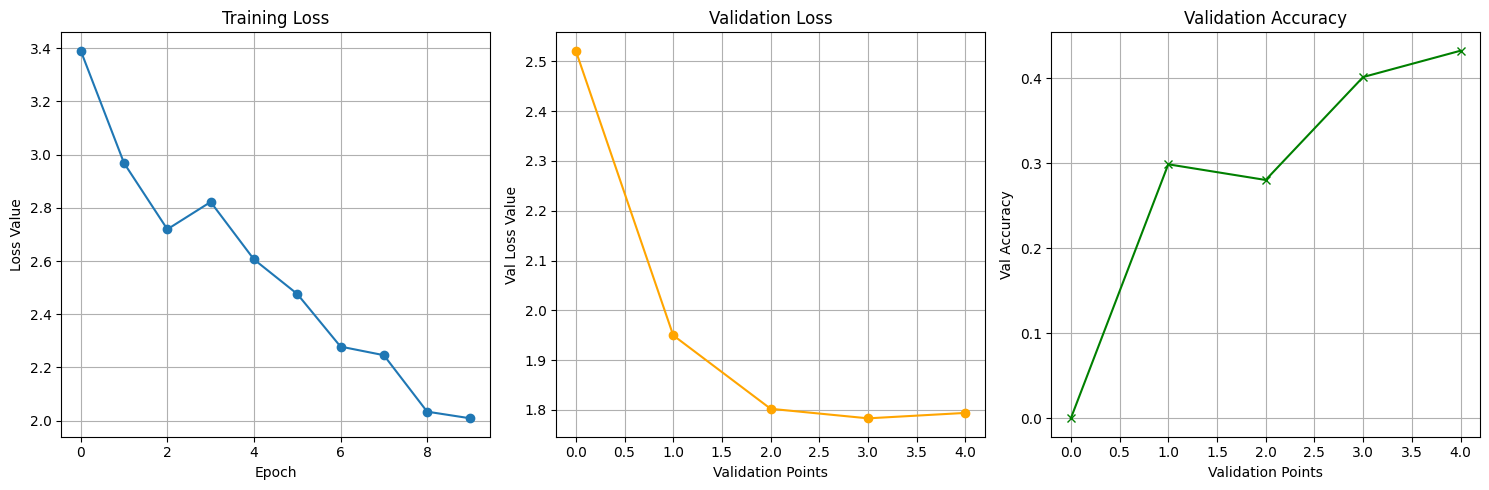

In [4]:
# Training & Validation Transforms
roi_size = [256, 256]
train_transforms = mt.Compose([
    LoadTiffd(keys=["image", "label"]),
    mt.EnsureTyped(
        keys=["image", "label"], data_type="tensor", dtype=torch.float
    ),
    mt.ScaleIntensityd(keys="image", minv=0, maxv=1, channel_wise=True),
    mt.ScaleIntensityRangePercentilesd(
        keys="image",
        lower=1,
        upper=99,
        b_min=0.0,
        b_max=1.0,
        channel_wise=True,
        clip=True,
    ),
    mt.SpatialPadd(keys=["image", "label"], spatial_size=roi_size),
    mt.RandSpatialCropd(keys=["image", "label"], roi_size=roi_size),
    mt.RandAffined(
        keys=["image", "label"],
        prob=0.5,
        rotate_range=np.pi,
        scale_range=[-0.5, 0.5],
        mode=["bilinear", "nearest"],
        spatial_size=roi_size,
        cache_grid=True,
        padding_mode="border",
    ),
    mt.RandAxisFlipd(keys=["image", "label"], prob=0.5),
    mt.RandGaussianNoised(keys=["image"], prob=0.25, mean=0, std=0.1),
    mt.RandAdjustContrastd(keys=["image"], prob=0.25, gamma=(1, 2)),
    mt.RandGaussianSmoothd(keys=["image"], prob=0.25, sigma_x=(1, 2)),
    mt.RandHistogramShiftd(keys=["image"], prob=0.25, num_control_points=3),
    mt.RandGaussianSharpend(keys=["image"], prob=0.25),
    LabelsToFlows(keys="label", flow_key="flow")
])

val_transforms = mt.Compose([
    LoadTiffd(keys=["image", "label"], allow_missing_keys=True),
    mt.EnsureTyped(
        keys=["image", "label"],
        data_type="tensor",
        dtype=torch.float,
        allow_missing_keys=True,
    ),
    mt.ScaleIntensityRangePercentilesd(
        keys="image",
        lower=1,
        upper=99,
        b_min=0.0,
        b_max=1.0,
        channel_wise=True,
        clip=True,
    ),
    LabelsToFlows(keys="label", flow_key="flow", allow_missing_keys=True)
])

# Datasets & Dataloaders for training, validation and testing
train_dataset = Dataset(
    data=training_list,
    transform=train_transforms
)
train_loader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    num_workers=2
)

val_dataset = Dataset(
    data=validation_list,
    transform=val_transforms
)
val_loader = DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=2
)

# Training loop with validation
loss_function = CellLoss()
acc_function = CellAcc()

# Define the Sliding Window Inferer
sliding_inferrer = SlidingWindowInfererAdapt(
    roi_size=[256, 256],
    sw_batch_size=1,
    overlap=0.25,
    cache_roi_weight_map=True,
    progress=False)

channels_last = True

ckpt_path = os.path.join(data_root, 'model_checkpoints')
if os.path.exists(ckpt_path) is False:
    os.mkdir(ckpt_path)
num_epochs = 10

num_epochs_per_validation = 2

# Optimizer 
optimizer = torch.optim.SGD(
    params=model.parameters(),
    momentum=0.9,
    lr=0.01,
    weight_decay=1e-5
)

# Amp 
scaler = GradScaler()
amp_dtype = torch.float16

best_ckpt_path = os.path.join(ckpt_path, "model.pt")
intermediate_ckpt_path = os.path.join(ckpt_path, "model_final.pt")

best_metric = -1
start_epoch = 0
best_metric_epoch = -1
epoch_loss_values = []
val_epoch_loss_values = []
val_epoch_acc_values = []
for epoch in range(0, num_epochs):
    start_time = time.time()
    train_loss, train_acc = 0, 0

    model.train()
    memory_format = torch.channels_last if channels_last else torch.preserve_format
    run_loss = CumulativeAverage()
    avg_loss = avg_acc = 0

    for idx, batch_data in enumerate(train_loader):
        data = (
            batch_data["image"]
            .as_subclass(torch.Tensor)
            .to(memory_format=memory_format, device=device)
        )

        target = (
            batch_data["flow"]
            .as_subclass(torch.Tensor)
            .to(memory_format=memory_format, device=device)
        )

        optimizer.zero_grad(set_to_none=True)

        # Use autocast with float16 for mixed precision training
        with autocast(dtype=amp_dtype):
            logits = model(data)
            loss = loss_function(logits.float(), target)

        # Use the scaler for backpropagation and optimization
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        batch_size = data.shape[0]
        run_loss.append(loss, count=batch_size)
        avg_loss = run_loss.aggregate()

        print(f"Epoch {epoch}/{num_epochs} {idx}/{len(train_loader)} ")
        print(f"loss: {avg_loss:.4f} time {time.time() - start_time:.2f}s ")

    optimizer.zero_grad()

    epoch_loss_values.append(avg_loss)

    # Validation loop & model checkpoints
    if epoch % num_epochs_per_validation == 0:
        optimizer.zero_grad(set_to_none=True)
        model = model.to(device)
        model.eval()

        with torch.no_grad():
            val_run_loss = CumulativeAverage()
            run_acc = CumulativeAverage()
            for val_idx, val_batch in enumerate(val_loader):
                v_data = (
                    val_batch["image"]
                    .as_subclass(torch.Tensor)
                    .to(memory_format=memory_format, device=device)
                )

                target = (
                    val_batch["flow"]
                    .as_subclass(torch.Tensor)
                    .to(device=device)
                )

                filename = val_batch["image"].meta[ImageMetaKey.FILENAME_OR_OBJ]
                batch_size = v_data.shape[0]
                loss = acc = None
                # Use autocast with float16 for mixed precision validation
                with autocast(dtype=amp_dtype):
                    logits = sliding_inferrer(inputs=v_data, network=model)
                    val_loss = loss_function(logits, target)

                val_run_loss.append(val_loss.to(device=device), count=batch_size)
                target = None

                pred_mask_all = []

                for b_ind in range(logits.shape[0]):  # go over batch dim
                    pred_mask, p = LogitsToLabels()(logits=logits[b_ind], filename=filename)
                    pred_mask_all.append(pred_mask)

                if acc_function is not None:
                    label = val_batch["label"].as_subclass(torch.Tensor)

                    for b_ind in range(label.shape[0]):
                        acc = acc_function(pred_mask_all[b_ind], label[b_ind, 0].long())
                        acc = (
                            acc.detach().clone()
                            if isinstance(acc, torch.Tensor)
                            else torch.tensor(acc)
                        )

                        run_acc.append(acc.to(device=device), count=1)
                    label = None

                avg_loss = val_loss.cpu() if val_loss is not None else 0
                avg_acc = acc.cpu().numpy() if acc is not None else 0

                print(f"Val {epoch}/{num_epochs} {val_idx}/{len(val_loader)} ")
                print(f"loss: {avg_loss:.4f} acc {avg_acc}  time {time.time() - start_time:.2f}s")

        val_epoch_loss_values.append(val_run_loss.aggregate())
        val_epoch_acc_values.append(run_acc.aggregate())
    # Model Saving & Checkpointing
    if avg_loss < best_metric:
        best_metric = avg_loss
        state_dict = model.state_dict()
        torch.save({"state_dict": state_dict}, best_ckpt_path)

# Loss plot visualization 
%matplotlib inline
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Loss
axs[0].plot(range(0, num_epochs), epoch_loss_values, marker='o')
axs[0].set_title('Training Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss Value')
axs[0].grid(True)

# Plot 2: Validation Loss
axs[1].plot(val_epoch_loss_values, marker='o', color='orange')
axs[1].set_title('Validation Loss')
axs[1].set_xlabel('Validation Points')
axs[1].set_ylabel('Val Loss Value')
axs[1].grid(True)

# Plot 3: Validation Accuracy
axs[2].plot(val_epoch_acc_values, marker='x', color='green')
axs[2].set_title('Validation Accuracy')
axs[2].set_xlabel('Validation Points')
axs[2].set_ylabel('Val Accuracy')
axs[2].grid(True)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

/tmp/ipykernel_1742509/2020416527.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=amp_dtype):


(3, 512, 478)
(512, 478)
(512, 478)


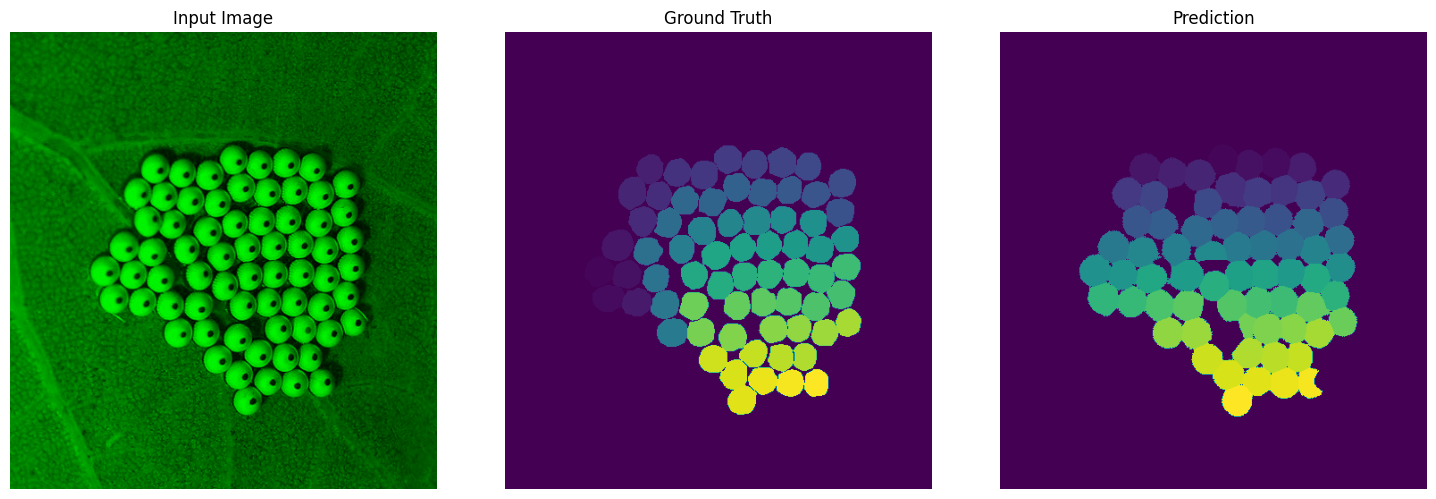

Image shape: (512, 478, 3)
Label shape: (512, 478)
Prediction shape: (512, 478)
Unique values in label: [0.         0.01470588 0.02941176 0.04411765 0.05882353 0.07352941
 0.0882353  0.10294118 0.11764706 0.13235295 0.14705883 0.16176471
 0.1764706  0.19117647 0.20588236 0.22058824 0.23529412 0.25
 0.2647059  0.27941176 0.29411766 0.30882353 0.32352942 0.3382353
 0.3529412  0.36764705 0.38235295 0.3970588  0.4117647  0.42647058
 0.44117647 0.45588234 0.47058824 0.4852941  0.5        0.5147059
 0.5294118  0.5441176  0.5588235  0.5735294  0.5882353  0.60294116
 0.61764705 0.63235295 0.64705884 0.6617647  0.6764706  0.6911765
 0.7058824  0.7205882  0.7352941  0.75       0.7647059  0.7794118
 0.7941176  0.8088235  0.8235294  0.8382353  0.85294116 0.86764705
 0.88235295 0.89705884 0.9117647  0.9264706  0.9411765  0.9558824
 0.9705882  0.9852941  1.        ]
Unique values in prediction: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34

In [5]:

# Define a transform to load and preprocess the image
preprocess = Compose([
    LoadImage(image_only=True),
    EnsureChannelFirst(),
    ScaleIntensity()
])

# Load a single validation image (index 2)
val_item = validation_list[2]
image_path = val_item['image']
label_path = val_item['label']

# Load and preprocess the image and label
image = preprocess(image_path)
label = preprocess(label_path)

# Ensure model is in eval mode and on the correct device
model.eval()
model.to(device)

# Perform inference
with torch.no_grad():
    input_tensor = torch.as_tensor(image).unsqueeze(0).to(device)
    with autocast(dtype=amp_dtype):
        logits = sliding_inferrer(inputs=input_tensor, network=model)

# Convert logits to prediction mask
pred_mask, _ = LogitsToLabels()(logits=logits[0])

# Move tensors to CPU and convert to numpy for visualization
image = image.squeeze().cpu().numpy()
label = label.squeeze().cpu().numpy()

print(image.shape)
print(label.shape)
print(pred_mask.shape)
# Plotting
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Handle potential multi-channel images
if image.ndim == 3 and image.shape[0] in [1, 3, 4]:
    image = np.transpose(image, (1, 2, 0))
    if image.shape[2] == 1:
        image = image[:, :, 0]

axes[0].imshow(image, cmap='gray' if image.ndim == 2 else None)
axes[0].set_title('Input Image')
axes[0].axis('off')

if label.ndim == 3 and label.shape[0] == 1:
    label = label[0]
axes[1].imshow(label, cmap='viridis')
axes[1].set_title('Ground Truth')
axes[1].axis('off')

if pred_mask.ndim == 3 and pred_mask.shape[0] == 1:
    pred_mask = pred_mask[0]
axes[2].imshow(pred_mask, cmap='viridis')
axes[2].set_title('Prediction')
axes[2].axis('off')

plt.tight_layout()
plt.show()

# Print some statistics
print(f"Image shape: {image.shape}")
print(f"Label shape: {label.shape}")
print(f"Prediction shape: {pred_mask.shape}")
print(f"Unique values in label: {np.unique(label)}")
print(f"Unique values in prediction: {np.unique(pred_mask)}")